# Real Time Audio Stream Classification

# Imports

In [4]:
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification
import torch
from torchinfo import summary
import time
import matplotlib.pyplot as plt
import torchaudio
import sounddevice as sd
import numpy as np

## 1. Pretrained Models

Let's start with one of the pretrained models to set up the groundwork for model selection. Later on, we can explore other more optimized models.

Starting off with 
- 7wolf/wav2vec2-base-gender-classification

### 1.1. Loading the pretrained model from Hugging Face


In [2]:
# Loading the pretrained model from Hugging Face
def load_pretrained_model(model_name: str):
    """
    Loads a pretrained model from Hugging Face.
    
    Args:
        model_name_or_path (str): The name or path of the model to load.
        
    Returns:
        model: The loaded model.
    """
    feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
    model = AutoModelForAudioClassification.from_pretrained(model_name)
    return feature_extractor, model

In [3]:
MODEL_NAME = "7wolf/wav2vec2-base-gender-classification"
feature_extractor, model = load_pretrained_model(MODEL_NAME)

In [51]:
# Create a dummy input representing a 1-second audio waveform at 16kHz
dummy_input = torch.randn(16000)

features = feature_extractor(dummy_input, return_tensors="pt", sampling_rate=16000, padding="longest")

print(features)

{'input_values': tensor([[ 0.9480, -1.0508, -2.2103,  ..., -0.1974,  1.4502,  0.9965]])}


In [52]:
print(features["input_values"].shape)

torch.Size([1, 16000])


In [53]:
prediction = model(features["input_values"])
print(prediction)

SequenceClassifierOutput(loss=None, logits=tensor([[-1.5780,  1.8712]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


In [54]:
summary(model, input_size=features["input_values"].shape)

Layer (type:depth-idx)                                  Output Shape              Param #
Wav2Vec2ForSequenceClassification                       [1, 2]                    --
├─Wav2Vec2Model: 1-1                                    [1, 49, 512]              768
│    └─Wav2Vec2FeatureEncoder: 2-1                      [1, 512, 49]              --
│    │    └─ModuleList: 3-1                             --                        4,200,448
│    └─Wav2Vec2FeatureProjection: 2-2                   [1, 49, 768]              --
│    │    └─LayerNorm: 3-2                              [1, 49, 512]              1,024
│    │    └─Linear: 3-3                                 [1, 49, 768]              393,984
│    │    └─Dropout: 3-4                                [1, 49, 768]              --
│    └─Wav2Vec2Encoder: 2-3                             [1, 49, 768]              --
│    │    └─Wav2Vec2PositionalConvEmbedding: 3-5        [1, 49, 768]              4,719,488
│    │    └─LayerNorm: 3-6           

The model is a simple extension of the wav2vec2-base model with a classification head added on top consisting of a single layer classifier

### 1.2 Latency Testing

We can generate a random audio waveform and pass it through the model to get a prediction

In [55]:
# Generate a random audio waveform
random_audio = torch.randn(1, 16000)

# Pass the random audio through the model
prediction = model(random_audio)

In [56]:
prediction

SequenceClassifierOutput(loss=None, logits=tensor([[-1.2984,  1.5251]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

We are able to get a prediction from the model that comprises of the logits for classification. We can now do a performance testing of the model to further understand the latency achieved.

In [245]:
# Create a wrapper function for the model inference
def run_inference(model_name, audio_data):
    with torch.no_grad():
        feature_extractor, model = load_pretrained_model(model_name)
        features = feature_extractor(audio_data, return_tensors="pt", sampling_rate=16000, padding="longest")
        logits = model(features["input_values"].squeeze(0)).logits
        return logits

/var/folders/c8/ykrv0lzn7pv_xypw3zhgm0sm0000gn/T/ipykernel_63658/3942287527.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(latency_data.values(), labels=latency_data.keys())


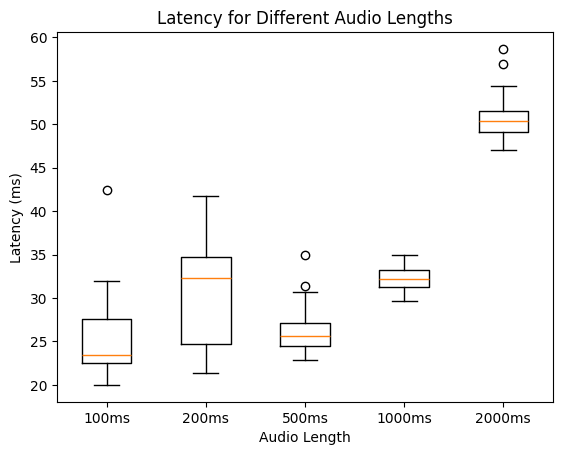

In [106]:
# Assuming a sample rate of 16kHz, we can generate random audio waveforms of different lengths (starting from 100ms going up to 2 seconds)

SAMPLING_RATE = 16000
random_audio_lengths = [0.1, 0.2, 0.5, 1, 2]
NUM_ITERATIONS = 50



# Dictionary to store latencies for each audio length
latency_data = {f'{int(length*1000)}ms': [] for length in random_audio_lengths}

# Loop through the different lengths and collect latency data
for length in random_audio_lengths:
    for _ in range(NUM_ITERATIONS):
        random_audio = torch.randn(1, int(length*SAMPLING_RATE))
        start = time.time()
        prediction = model(random_audio)
        end = time.time()
        latency_data[f'{int(length*1000)}ms'].append((end - start) * 1000)  # Convert to milliseconds

# Plot a single box plot for all latencies
plt.figure()
plt.boxplot(latency_data.values(), labels=latency_data.keys())
plt.xlabel('Audio Length')
plt.ylabel('Latency (ms)')
plt.title('Latency for Different Audio Lengths')
plt.show()


We are able to get <50ms latency for 100ms audio length, which is suitable for real time processing. Now let's do some analysis on the predictions with real world audio data.

### 1.3 Performance Analysis with Real World Audio Data

In [107]:
# Load the audio data
def load_audio_data(audio_path: str):
    """
    Loads an audio file and returns the audio data and sampling rate.
    
    Args:
        audio_path (str): The path to the audio file.   
    
    Returns:
        audio_data (torch.Tensor): The audio data.
        sampling_rate (int): The sampling rate of the audio data.
    """
    audio_data, sampling_rate = torchaudio.load(audio_path)
    return audio_data, sampling_rate

def downsample_and_trim_audio(audio_data, sampling_rate, target_sampling_rate=16000, max_duration=2):
    """
    Downsamples and trims an audio signal to a target sampling rate and maximum duration.
    
    Args:
        audio_data (torch.Tensor): The audio data.
        sampling_rate (int): The sampling rate of the audio data.
        target_sampling_rate (int): The target sampling rate to downsample to.
        max_duration (float): The maximum duration of the audio to trim to.
    
    Returns:
        audio_data (torch.Tensor): The downsampled and trimmed audio data.
        sampling_rate (int): The sampling rate of the downsampled and trimmed audio data.
    """
    # Downsample the audio data to the target sampling rate
    audio_data = torchaudio.functional.resample(audio_data, sampling_rate, target_sampling_rate)
    
    # Keep only the first channel
    audio_data = audio_data[0, :].unsqueeze(0)
    
    # Trim the audio data to the maximum duration
    audio_data = audio_data[:, :int(target_sampling_rate * max_duration)]
    
    return audio_data, target_sampling_rate

male_audio_path = "data/intoxiqatorz-107314.mp3"
female_audio_path = "data/female-blurb-105836.mp3"
ambient_audio_path = "data/ambience_coffee_shop.mp3"

male_audio_data, male_sampling_rate = load_audio_data(male_audio_path)
female_audio_data, female_sampling_rate = load_audio_data(female_audio_path)
ambient_audio_data, ambient_sampling_rate = load_audio_data(ambient_audio_path)

print("Raw input audio data shape and sampling rate:")
print(male_audio_data.shape, male_sampling_rate)
print(female_audio_data.shape, female_sampling_rate)
print(ambient_audio_data.shape, ambient_sampling_rate)

# Downsampling to 16kHz and keeping the first 2 seconds of the audio
male_audio_data_processed, male_sampling_rate = downsample_and_trim_audio(male_audio_data, male_sampling_rate, target_sampling_rate=16000, max_duration=2)
female_audio_data_processed, female_sampling_rate = downsample_and_trim_audio(female_audio_data, female_sampling_rate, target_sampling_rate=16000, max_duration=2)
ambient_audio_data_processed, ambient_sampling_rate = downsample_and_trim_audio(ambient_audio_data, ambient_sampling_rate, target_sampling_rate=16000, max_duration=2)

print("Downsampled and trimmed audio data shape and sampling rate:")
print(male_audio_data_processed.shape, male_sampling_rate)
print(female_audio_data_processed.shape, female_sampling_rate)
print(ambient_audio_data_processed.shape, ambient_sampling_rate)


Raw input audio data shape and sampling rate:
torch.Size([1, 252288]) 44100
torch.Size([1, 208512]) 44100
torch.Size([2, 254639]) 24000
Downsampled and trimmed audio data shape and sampling rate:
torch.Size([1, 32000]) 16000
torch.Size([1, 32000]) 16000
torch.Size([1, 32000]) 16000


In [108]:
# Playing back the audio for a sanity check
print("Playing back the audio for a sanity check")


sd.play(male_audio_data_processed.numpy().T, SAMPLING_RATE)
sd.wait()
sd.play(female_audio_data_processed.numpy().T, SAMPLING_RATE)
sd.wait()
sd.play(ambient_audio_data_processed.numpy().T, SAMPLING_RATE)
sd.wait()


Playing back the audio for a sanity check


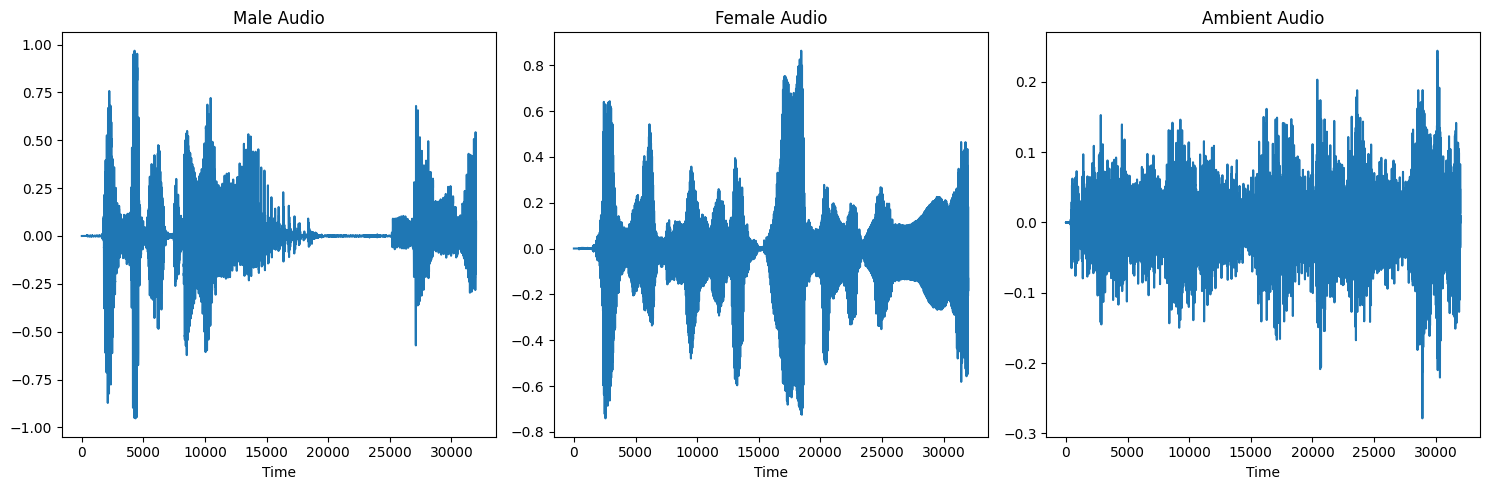

In [142]:
# Plot the waveforms of the processed audio data
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(male_audio_data_processed.numpy().T)
plt.title("Male Audio")
plt.xlabel("Time")

plt.subplot(1, 3, 2)
plt.plot(female_audio_data_processed.numpy().T)
plt.title("Female Audio")
plt.xlabel("Time")

plt.subplot(1, 3, 3)
plt.plot(ambient_audio_data_processed.numpy().T)
plt.title("Ambient Audio")
plt.xlabel("Time")

plt.tight_layout()
plt.show()

#### Key Observations
- The ambient audio has a lower amplitude than the male and female audio.
    - Root RMS value can be used to quickly differentiate ambient audio from the other two.



In [111]:
# Generating predictions for the processed audio data
male_prediction = run_inference(model_name=MODEL_NAME, random_audio=male_audio_data_processed.squeeze(0))
female_prediction = run_inference(model_name=MODEL_NAME, random_audio=female_audio_data_processed.squeeze(0))
ambient_prediction = run_inference(model_name=MODEL_NAME, random_audio=ambient_audio_data_processed.squeeze(0))

print("Male prediction:")
print(male_prediction.argmax(dim=-1))

print("Female prediction:")
print(female_prediction.argmax(dim=-1))

print("Ambient prediction:")
print(ambient_prediction.argmax(dim=-1))



Male prediction:
tensor([0])
Female prediction:
tensor([1])
Ambient prediction:
tensor([1])


In [122]:
# Splitting all audios into 100ms chunks and predicting each chunk
male_audio_data_processed_splitted = male_audio_data_processed.unfold(1, 1600, 1600).squeeze(0)
female_audio_data_processed_splitted = female_audio_data_processed.unfold(1, 1600, 1600).squeeze(0) 
ambient_audio_data_processed_splitted = ambient_audio_data_processed.unfold(1, 1600, 1600).squeeze(0)

splitted_test_data = {
    "male": male_audio_data_processed_splitted,
    "female": female_audio_data_processed_splitted,
    "ambient": ambient_audio_data_processed_splitted
}

for key, value in splitted_test_data.items():
    print(key, value.shape)


male torch.Size([20, 1600])
female torch.Size([20, 1600])
ambient torch.Size([20, 1600])


male
female
ambient


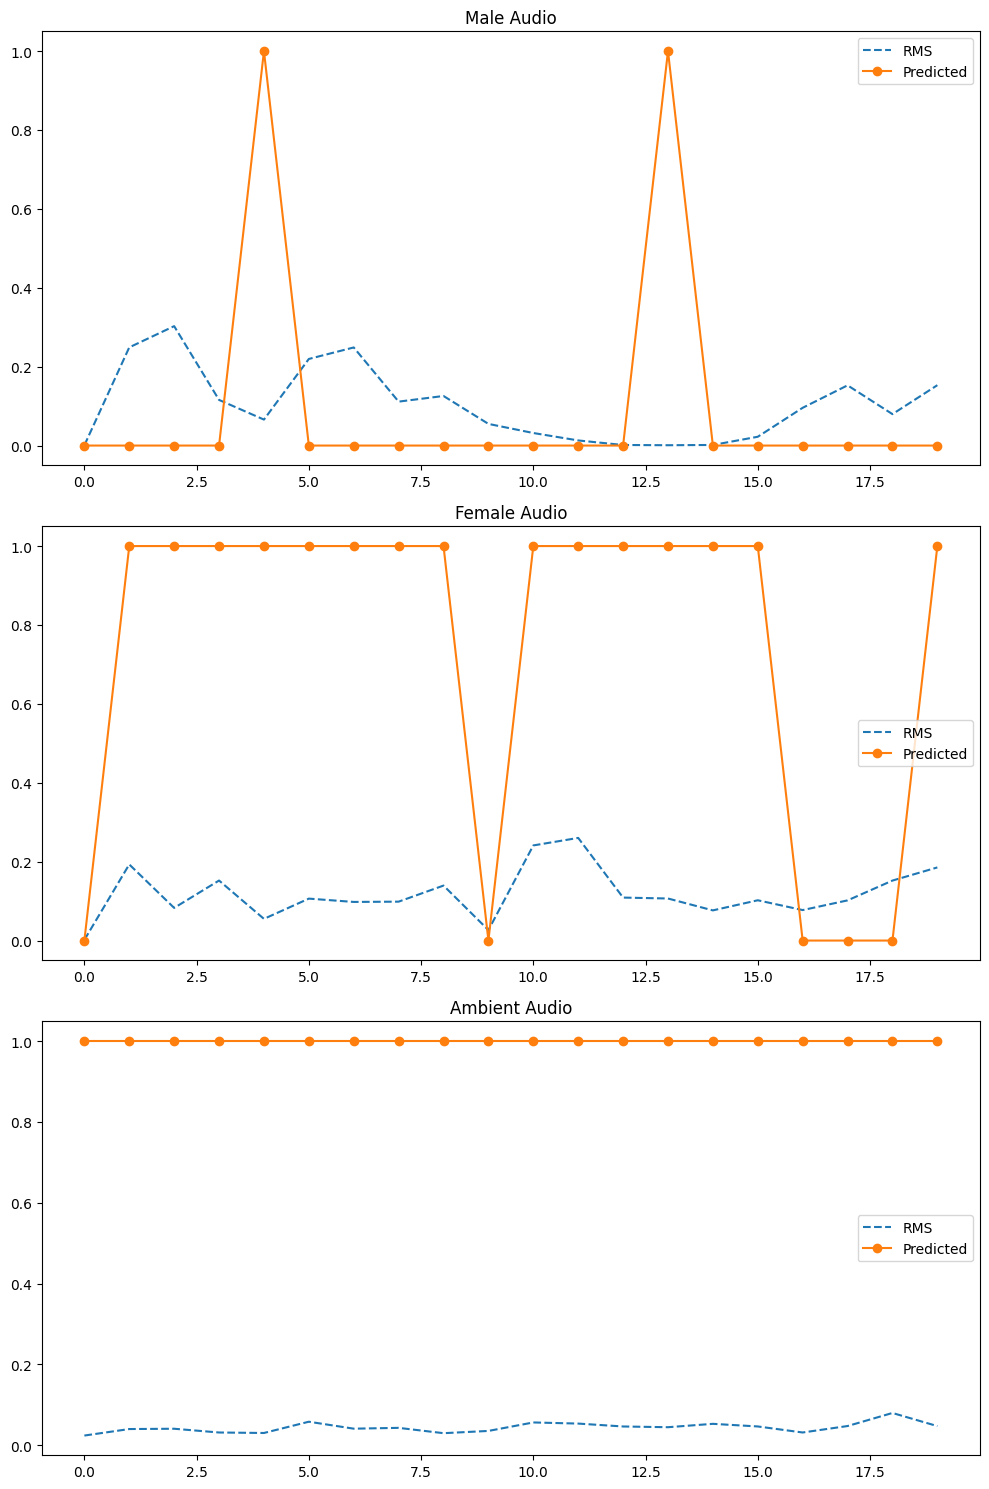

In [128]:
import matplotlib.pyplot as plt
import numpy as np

rms_values = {
    "male": [],
    "female": [],
    "ambient": []
}

predicted_values = {
    "male": [],
    "female": [],
    "ambient": []
}

for key, value in splitted_test_data.items():
    print(key)
    for chunk in value:
        rms_value = np.sqrt(np.mean(chunk.numpy() ** 2))
        rms_values[key].append(rms_value)
        
        prediction = run_inference(model_name=MODEL_NAME, audio_data=chunk)
        predicted_class = prediction.argmax(dim=-1).item()
        predicted_values[key].append(predicted_class)

# Plotting RMS vs predicted values
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

for i, key in enumerate(splitted_test_data.keys()):
    axes[i].plot(rms_values[key], label='RMS', linestyle='--')
    axes[i].plot(predicted_values[key], label='Predicted', marker='o')
    axes[i].set_title(f'{key.capitalize()} Audio')
    axes[i].legend()

plt.tight_layout()
plt.show()

Misclasssifications are generally correlated with the RMS value. If the chunk consists of a pause in the speech, the model is unable to classify it correctly. Lets modify the run inference function to include a threshold for the RMS value.

In [140]:
CLASSES = ["male", "female", "uncertain"]
def run_inference_with_threshold(model_name, audio_data, threshold=0.1):
    
    rms_value = np.sqrt(np.mean(audio_data.numpy() ** 2))
    if rms_value < threshold:
        return CLASSES[2]
    else:
        prediction = run_inference(model_name, audio_data).argmax(dim=-1).item()
        return CLASSES[prediction]


male
female
ambient
{'male': ['uncertain', 'male', 'male', 'male', 'female', 'male', 'male', 'male', 'male', 'male', 'uncertain', 'uncertain', 'uncertain', 'uncertain', 'uncertain', 'uncertain', 'male', 'male', 'male', 'male'], 'female': ['uncertain', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'uncertain', 'female', 'female', 'female', 'female', 'female', 'female', 'male', 'male', 'male', 'female'], 'ambient': ['uncertain', 'uncertain', 'uncertain', 'uncertain', 'uncertain', 'female', 'uncertain', 'uncertain', 'uncertain', 'uncertain', 'female', 'female', 'uncertain', 'uncertain', 'female', 'uncertain', 'uncertain', 'uncertain', 'female', 'uncertain']}


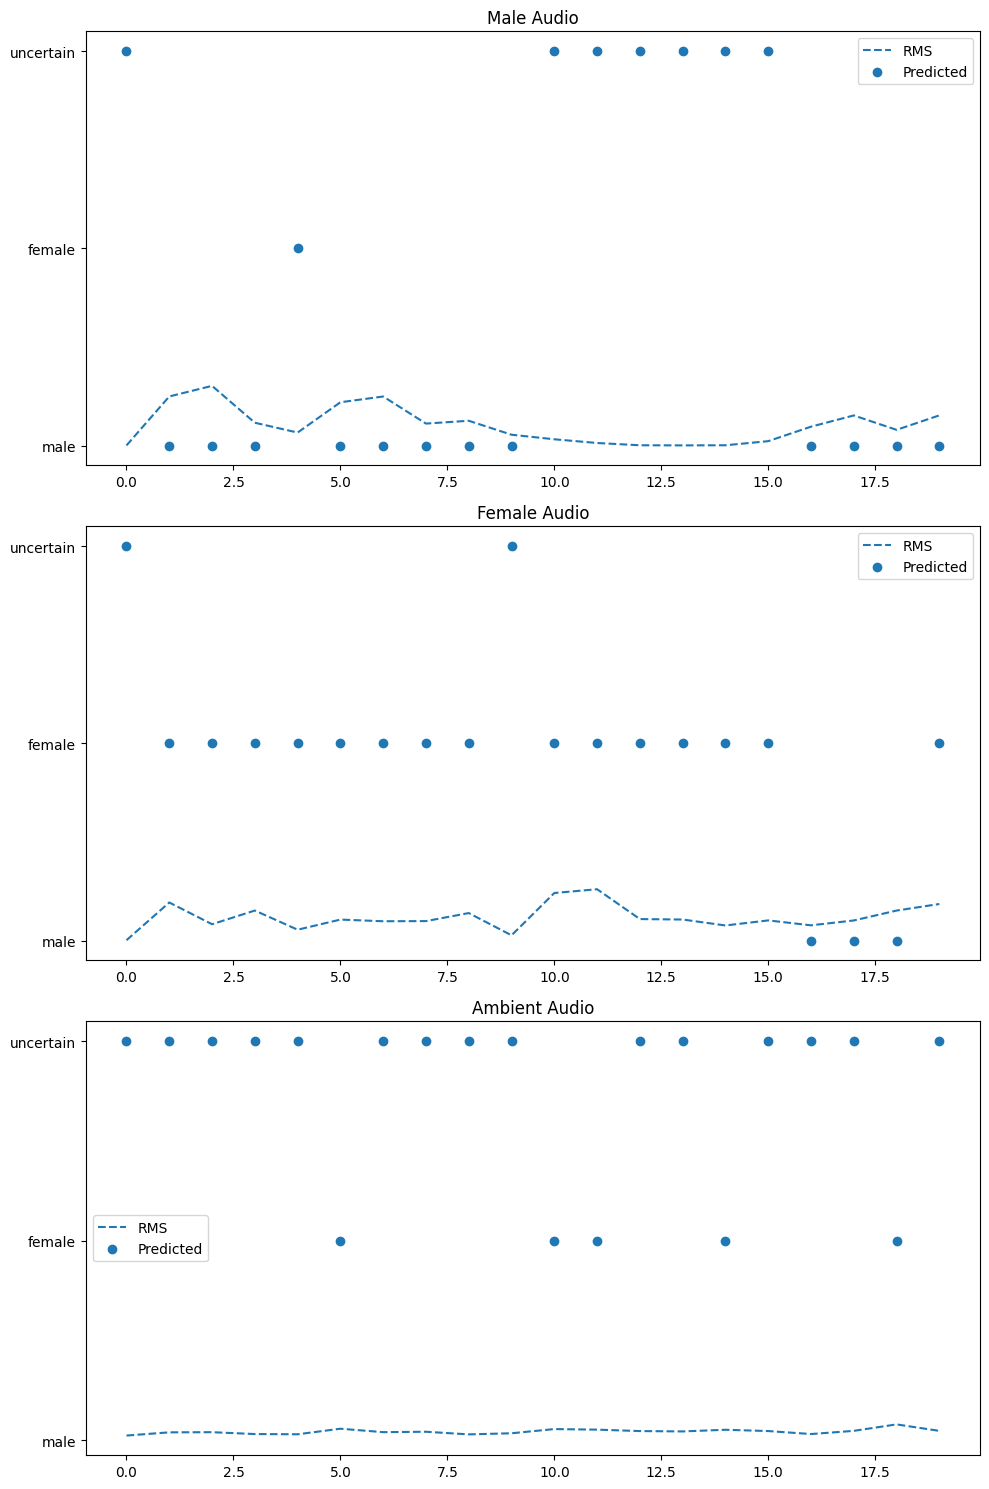

In [ ]:
THRESHOLD = 0.05

rms_values = {
    "male": [],
    "female": [],
    "ambient": []
}

predicted_values = {
    "male": [],
    "female": [],
    "ambient": []
}

for key, value in splitted_test_data.items():
    print(key)
    for chunk in value:
        rms_value = np.sqrt(np.mean(chunk.numpy() ** 2))
        rms_values[key].append(rms_value)
        
        prediction = run_inference_with_threshold(model_name=MODEL_NAME, audio_data=chunk, threshold=THRESHOLD)
        predicted_class = prediction
        predicted_values[key].append(predicted_class)

print(predicted_values)




Most of the classifications seem to be correct, but there are some misclassifications. Lets try to improve the inference.

### 1.4 Performance Improvements

In [147]:
# Taking a majority vote of the last 3 predictions
predicted_values = {
    "male": [],
    "female": [],
    "ambient": []
}

for key, value in splitted_test_data.items():
    print(key)
    for chunk in value:
        prediction = run_inference_with_threshold(model_name=MODEL_NAME, audio_data=chunk, threshold=THRESHOLD)
        predicted_values[key].append(prediction)

print(predicted_values)

male
female
ambient
{'male': ['uncertain', 'male', 'male', 'male', 'female', 'male', 'male', 'male', 'male', 'male', 'uncertain', 'uncertain', 'uncertain', 'uncertain', 'uncertain', 'uncertain', 'male', 'male', 'male', 'male'], 'female': ['uncertain', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'uncertain', 'female', 'female', 'female', 'female', 'female', 'female', 'male', 'male', 'male', 'female'], 'ambient': ['uncertain', 'uncertain', 'uncertain', 'uncertain', 'uncertain', 'female', 'uncertain', 'uncertain', 'uncertain', 'uncertain', 'female', 'female', 'uncertain', 'uncertain', 'female', 'uncertain', 'uncertain', 'uncertain', 'female', 'uncertain']}


In [151]:
from collections import Counter

def majority_vote_last_n(predictions, n=3):
    """
    Takes a majority vote of the last N values in an array.
    
    Args:
    predictions (list): List of predicted values.
    n (int): Number of last values to consider for majority voting.
    
    Returns:
    The majority voted value among the last N values. If there's a tie, the most recent value is returned.
    """
    if len(predictions) < n:
        return predictions[-1] if predictions else None
    
    last_n = predictions[-n:]
    vote_count = Counter(last_n)
    
    # Find the majority vote, resolving ties by choosing the most recent value
    majority_vote = max(last_n, key=lambda x: (vote_count[x], last_n[::-1].index(x)))
    
    return majority_vote

# Example usage:
predictions = ['class1', 'class2', 'class1', 'class3', 'class1']
print(predictions)
print(majority_vote_last_n(predictions, n=3))  # Output: 'class1'
print(majority_vote_last_n(predictions, n=2))  # Output: 'class1'


['class1', 'class2', 'class1', 'class3', 'class1']
class1
class3


{'male': ['uncertain', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'uncertain', 'uncertain', 'uncertain', 'uncertain', 'uncertain', 'uncertain', 'male', 'male'], 'female': ['uncertain', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'male', 'male'], 'ambient': ['uncertain', 'uncertain', 'uncertain', 'uncertain', 'uncertain', 'uncertain', 'uncertain', 'uncertain', 'uncertain', 'uncertain', 'uncertain', 'uncertain', 'female', 'female', 'uncertain', 'uncertain', 'uncertain', 'uncertain', 'uncertain', 'uncertain']}


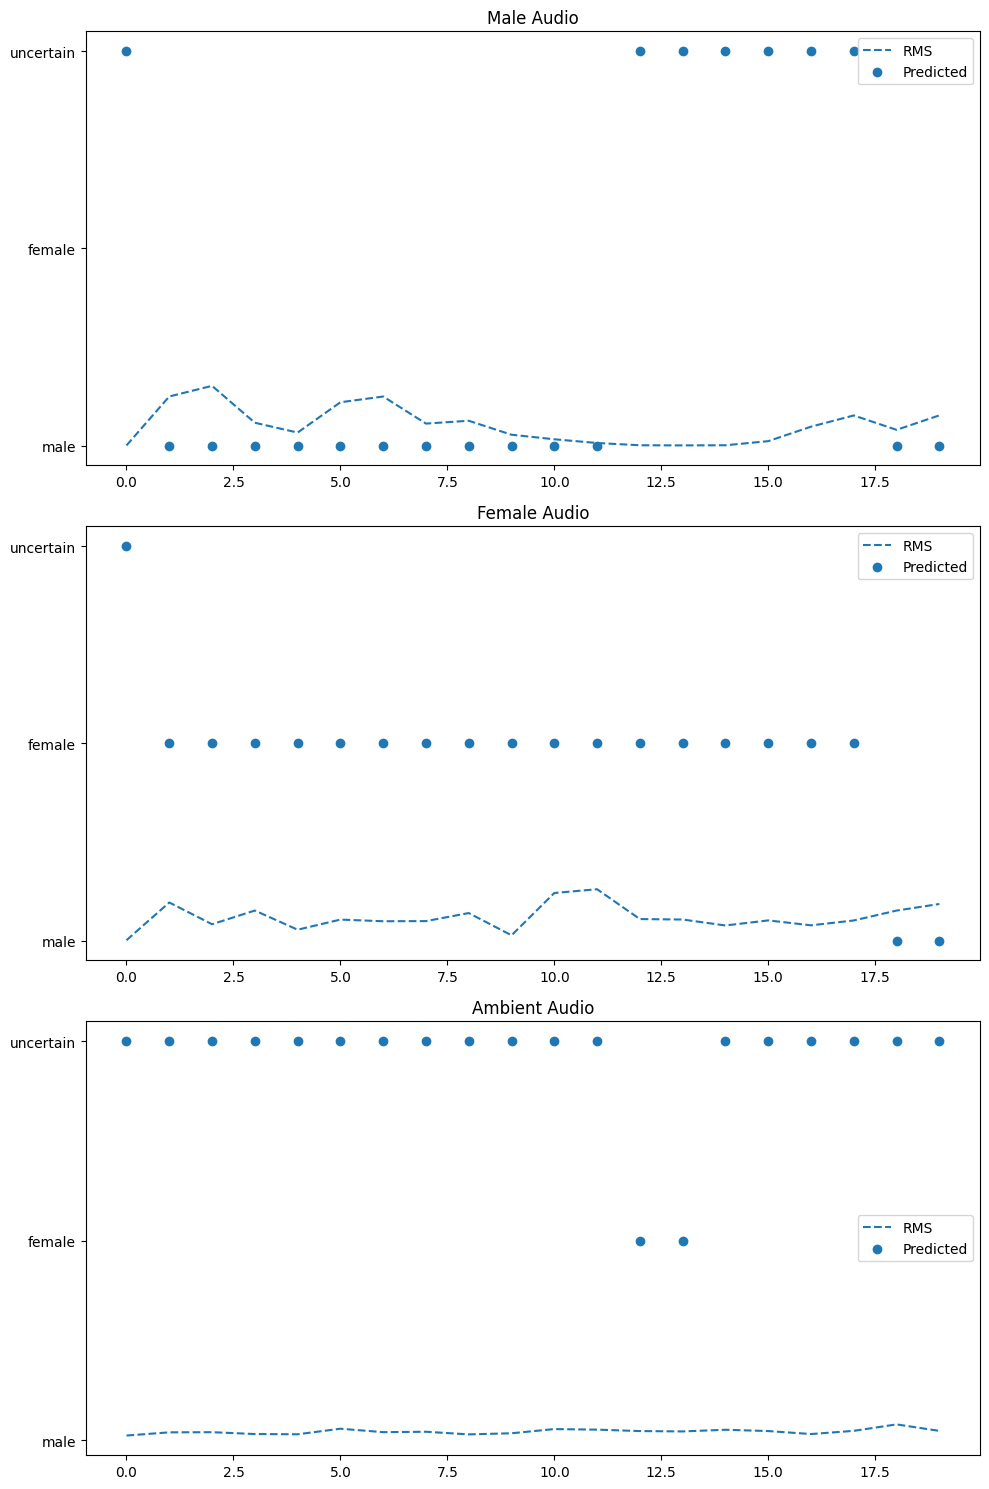

In [154]:
N = 4

# Repeat the inference with the majority vote
predicted_values_majority_vote = {}

for key, values in predicted_values.items():
    predicted_values_majority_vote[key] = [majority_vote_last_n(values[:i+1], N) for i in range(len(values))]

print(predicted_values_majority_vote)

# Plotting RMS vs predicted values
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

for i, key in enumerate(splitted_test_data.keys()):
    axes[i].plot(rms_values[key], label='RMS', linestyle='--')
    # Convert predicted class labels to their corresponding indices
    predicted_indices = [CLASSES.index(pred) for pred in predicted_values_majority_vote[key]]
    axes[i].scatter(range(len(predicted_indices)), predicted_indices, label='Predicted', marker='o')
    axes[i].set_title(f'{key.capitalize()} Audio')
    axes[i].set_yticks(range(len(CLASSES)))
    axes[i].set_yticklabels(CLASSES)
    axes[i].legend()

plt.tight_layout()
plt.show()

In [156]:
# Lets dig deep and do an audio verification. Loop through the predictions for each chunk and play the audio.
for key, values in predicted_values_majority_vote.items():
    for i, value in enumerate(values):
        if value in CLASSES:
            print(f"{value.capitalize()} audio at index {i}")
            sd.play(splitted_test_data[key][i].numpy().T, SAMPLING_RATE)
            sd.wait()

Uncertain audio at index 0
Male audio at index 1
Male audio at index 2
Male audio at index 3
Male audio at index 4
Male audio at index 5
Male audio at index 6
Male audio at index 7
Male audio at index 8
Male audio at index 9
Male audio at index 10
Male audio at index 11
Uncertain audio at index 12
Uncertain audio at index 13
Uncertain audio at index 14
Uncertain audio at index 15
Uncertain audio at index 16
Uncertain audio at index 17
Male audio at index 18
Male audio at index 19
Uncertain audio at index 0
Female audio at index 1
Female audio at index 2
Female audio at index 3
Female audio at index 4
Female audio at index 5
Female audio at index 6
Female audio at index 7
Female audio at index 8
Female audio at index 9
Female audio at index 10
Female audio at index 11
Female audio at index 12
Female audio at index 13
Female audio at index 14
Female audio at index 15
Female audio at index 16
Female audio at index 17
Male audio at index 18
Male audio at index 19
Uncertain audio at index 0

Audio playback confirms that the "misclassifications" or only during the quiet periods between words or sentences. We can try another approach here which involves overlapping chunks.

#### Overlapping Chunks

In [193]:
WINDOW_SIZE_IN_SECONDS = 0.1
OVERLAP_RATIO = 0.5
WINDOW_SIZE = int(SAMPLING_RATE*WINDOW_SIZE_IN_SECONDS)
OVERLAP_SIZE = int(WINDOW_SIZE*OVERLAP_RATIO)

male_audio_data_overlapping_chunks = male_audio_data_processed.unfold(1, WINDOW_SIZE, OVERLAP_SIZE).squeeze(0)
female_audio_data_overlapping_chunks = female_audio_data_processed.unfold(1, WINDOW_SIZE, OVERLAP_SIZE).squeeze(0)
ambient_audio_data_overlapping_chunks = ambient_audio_data_processed.unfold(1, WINDOW_SIZE, OVERLAP_SIZE).squeeze(0)

print(male_audio_data_overlapping_chunks.shape)
print(female_audio_data_overlapping_chunks.shape)
print(ambient_audio_data_overlapping_chunks.shape)

# First try with run inference on the overlapping chunks
predicted_values_overlapping_chunks = {"male": [], "female": [], "ambient": []}

for key, value in splitted_test_data.items():
    print(key)
    for chunk in value:
        prediction = run_inference_with_threshold(model_name=MODEL_NAME, audio_data=chunk, threshold=0)
        predicted_values_overlapping_chunks[key].append(prediction)
        
print(predicted_values_overlapping_chunks)


torch.Size([39, 1600])
torch.Size([39, 1600])
torch.Size([39, 1600])
male
female
ambient
{'male': ['male', 'male', 'male', 'male', 'female', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'female', 'male', 'male', 'male', 'male', 'male', 'male'], 'female': ['male', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'male', 'female', 'female', 'female', 'female', 'female', 'female', 'male', 'male', 'male', 'female'], 'ambient': ['female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female']}


In [203]:
WINDOW_SIZE_IN_SECONDS = 0.1
OVERLAP_RATIO = 0.5
WINDOW_SIZE = int(SAMPLING_RATE*WINDOW_SIZE_IN_SECONDS)
OVERLAP_SIZE = int(WINDOW_SIZE*OVERLAP_RATIO)

# First try with run inference on the overlapping chunks
predicted_values_overlapping_chunks_with_threshold = {"male": [], "female": [], "ambient": []}

for key, value in splitted_test_data.items():
    print(key)
    for chunk in value:
        prediction = run_inference_with_threshold(model_name=MODEL_NAME, audio_data=chunk, threshold=THRESHOLD)
        predicted_values_overlapping_chunks_with_threshold[key].append(prediction)

print(predicted_values_overlapping_chunks_with_threshold)


male
female
ambient
{'male': ['uncertain', 'male', 'male', 'male', 'female', 'male', 'male', 'male', 'male', 'male', 'uncertain', 'uncertain', 'uncertain', 'uncertain', 'uncertain', 'uncertain', 'male', 'male', 'male', 'male'], 'female': ['uncertain', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'uncertain', 'female', 'female', 'female', 'female', 'female', 'female', 'male', 'male', 'male', 'female'], 'ambient': ['uncertain', 'uncertain', 'uncertain', 'uncertain', 'uncertain', 'female', 'uncertain', 'uncertain', 'uncertain', 'uncertain', 'female', 'female', 'uncertain', 'uncertain', 'female', 'uncertain', 'uncertain', 'uncertain', 'female', 'uncertain']}


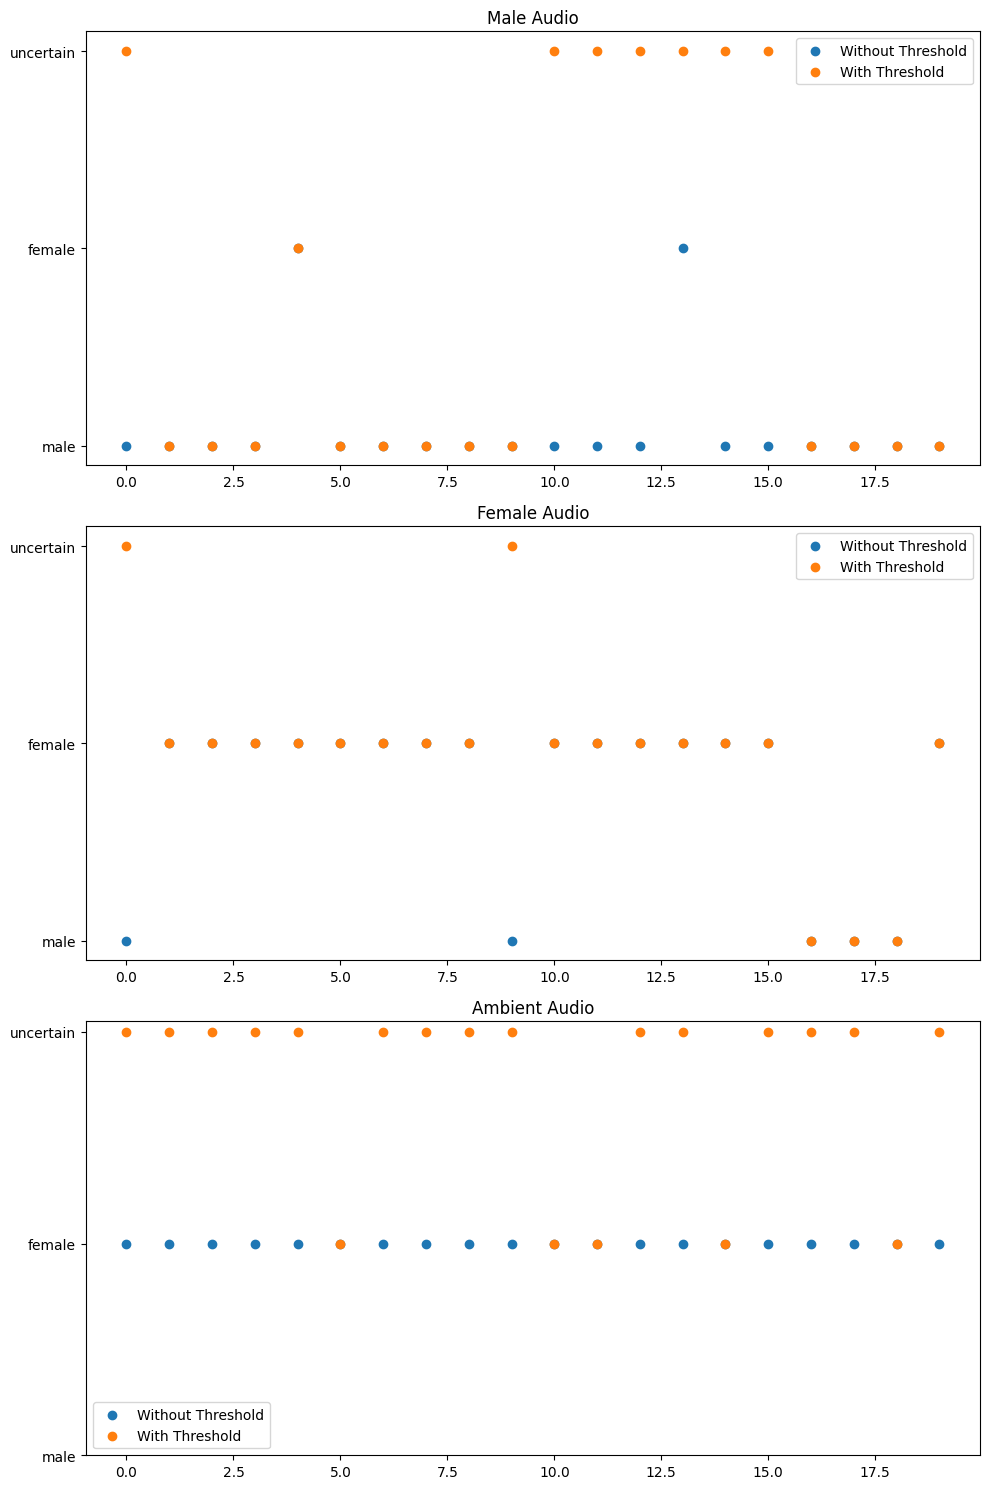

In [254]:
def plot_combined_predicted_values(splitted_test_data, predicted_values_list, labels, classes, figsize=(10, 15)):
    """
    Plots combined predicted values for given test data and multiple sets of predicted values.

    Parameters:
    - splitted_test_data: dict, keys are categories and values are lists of audio chunks
    - predicted_values_list: list of dicts, each dict has keys as categories and values as lists of predicted class labels
    - labels: list, labels for each set of predicted values
    - classes: list, list of class labels
    - figsize: tuple, size of the figure to plot
    """
    fig, axes = plt.subplots(len(splitted_test_data), 1, figsize=figsize)

    for i, key in enumerate(splitted_test_data.keys()):
        for predicted_values, label in zip(predicted_values_list, labels):
            # Convert predicted class labels to their corresponding indices
            predicted_indices = [classes.index(pred) for pred in predicted_values[key]]
            axes[i].scatter(range(len(predicted_indices)), predicted_indices, label=label, marker='o')
        axes[i].set_title(f'{key.capitalize()} Audio')
        axes[i].set_yticks(range(len(classes)))
        axes[i].set_yticklabels(classes)
        axes[i].legend()

    plt.tight_layout()
    plt.show()

# Example usage
plot_combined_predicted_values(
    splitted_test_data, 
    [predicted_values_overlapping_chunks, predicted_values_overlapping_chunks_with_threshold], 
    ['Without Threshold', 'With Threshold'], 
    CLASSES
)

#### Overlapping Chunks with Majority Vote

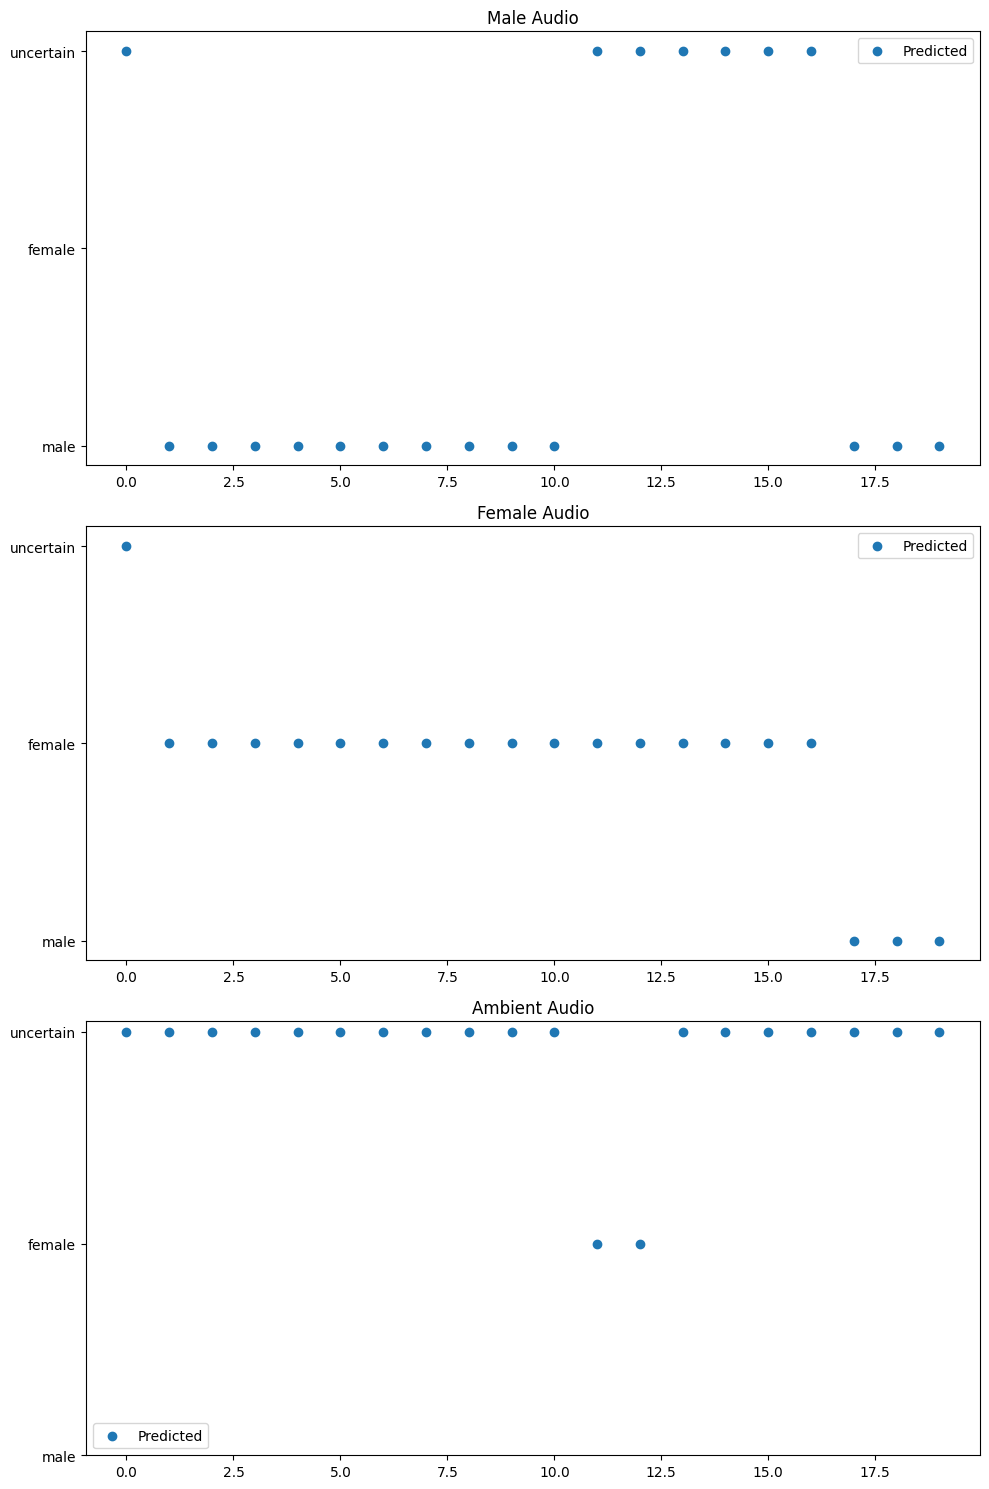

In [225]:
N = 3

# Apply majority vote to the overlapping chunks both with and without threshold
predicted_values_overlapping_chunks_majority_vote_with_threshold = {}

for key, values in predicted_values_overlapping_chunks_with_threshold.items():
    predicted_values_overlapping_chunks_majority_vote_with_threshold[key] = [majority_vote_last_n(values[:i+1], N) for i in range(len(values))]

# Plotting the majority voted values
plot_predicted_values(splitted_test_data, predicted_values_overlapping_chunks_majority_vote_with_threshold, CLASSES)


The results are little more stable and contain less jitter.

#### Batched inference

We can try to improve the inference by running the inference in batches. Idea is to keep a queue of chunks and run the inference only when we have enough chunks

In [307]:
def id2label(id, classes=["male", "female", "uncertain"]):
    return classes[id]

import torch.nn as nn

class BatchedInferenceWithThreshold(nn.Module):
    def __init__(self, model_name, threshold=0.1):
        super(BatchedInferenceWithThreshold, self).__init__()
        self.feature_extractor, self.classifier = load_pretrained_model(model_name)
        self.threshold = threshold

    def forward(self, audio_data_batch):
        # Audio data batch is a tensor of shape (batch_size, num_samples) [assuming mono channel]
        # For RMS thresholding, we need to calculate average RMS value across all chunks in the batch
        rms_value = np.mean(np.sqrt(np.mean(audio_data_batch.numpy() ** 2, axis=1)))
        if rms_value < self.threshold:
            return CLASSES[2]
        else:
            # Run inference on the batch
            features = self.feature_extractor(audio_data_batch, return_tensors="pt", sampling_rate=16000, padding="longest")
            predicted_logits = self.classifier(features["input_values"].squeeze(0)).logits
            predicted_labels = predicted_logits.argmax(dim=-1)
            return torch.mode(predicted_labels).values  


In [311]:
# Emulate batched inference
batch_size = 10


feature_extractor, classifer = load_pretrained_model(MODEL_NAME)
model = BatchedInferenceWithThreshold(MODEL_NAME)   

# Time the model
batch_random_audio = torch.randn(10, 1600)
with torch.inference_mode():
    start_time = time.time()
    for _ in range(10):
        model(batch_random_audio)
    end_time = time.time()
print(f"Time for 10 forward passes: {end_time - start_time} seconds")

# Compare with sequential inference
batch_random_audio = torch.randn(1, 1600)
with torch.inference_mode():
    start_time = time.time()
    for _ in range(100):
        model(batch_random_audio)
    end_time = time.time()
print(f"Time for 10 forward passes: {end_time - start_time} seconds")

Time for 10 forward passes: 0.5375001430511475 seconds
Time for 10 forward passes: 3.747598886489868 seconds


In [1]:
from utils import BatchedInferenceWithThreshold

In [2]:
model = BatchedInferenceWithThreshold("7wolf/wav2vec2-base-gender-classification")

In [ ]:
random_input = numpy.